In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings

warnings.filterwarnings("ignore")


In [2]:
# Replace with the exact names of your uploaded CSVs
csv_files = [
    "raw_material_quality_0.csv",
    "raw_material_quality_1.csv",
    "raw_material_quality_2.csv",
    "raw_material_quality_3.csv",
    "raw_material_quality_4.csv"
]

# Read and concatenate the data
df_list = [pd.read_csv(file) for file in csv_files]
raw_data = pd.concat(df_list, ignore_index=True)

raw_data.head()


,material_id,fiber_length,moisture_content,measurement_unit,timestamp
0,D,28.074787,11.716400,inches,2024-01-01 00:00:00
1,B,32.148304,9.447040,mm,2024-01-01 01:00:00
2,A,23.940239,14.963027,mm,2024-01-01 02:00:00
3,D,245.983137,15.318553,mm,2024-01-01 03:00:00
4,D,27.026989,12.000279,mm,2024-01-01 04:00:00


In [3]:
print(raw_data.info())
print(raw_data.describe(include="all"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   material_id       459 non-null    object 
 1   fiber_length      413 non-null    float64
 2   moisture_content  413 non-null    float64
 3   measurement_unit  459 non-null    object 
 4   timestamp         459 non-null    object 
dtypes: float64(2), object(3)
memory usage: 18.1+ KB
None
       material_id  fiber_length  moisture_content measurement_unit  \
count          459    413.000000        413.000000              459   
unique           4           NaN               NaN                3   
top              D           NaN               NaN               mm   
freq           125           NaN               NaN              167   
mean           NaN     36.543402         11.988410              NaN   
std            NaN     53.316335          1.852701              NaN   
min         

Missing values:
 material_id          0
fiber_length        46
moisture_content    46
measurement_unit     0
timestamp            0
dtype: int64


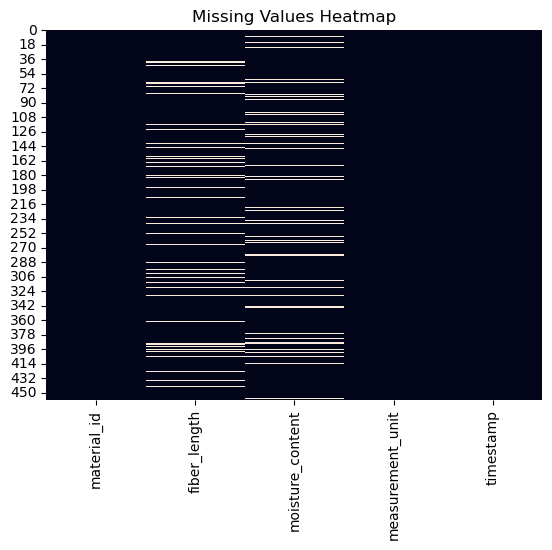

In [4]:
# Check for missing values
print("Missing values:\n", raw_data.isnull().sum())

# Visualize missing values
sns.heatmap(raw_data.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


In [5]:
# Fill missing values with median
raw_data['fiber_length'] = raw_data['fiber_length'].fillna(raw_data['fiber_length'].median())
raw_data['moisture_content'] = raw_data['moisture_content'].fillna(raw_data['moisture_content'].median())


In [6]:
# Convert fiber_length to mm based on the unit
def convert_to_mm(row):
    value = row['fiber_length']
    unit = row['measurement_unit']
    if unit == 'inches':
        return value * 25.4
    elif unit == 'cm':
        return value * 10
    return value  # already mm

raw_data['fiber_length_mm'] = raw_data.apply(convert_to_mm, axis=1)


In [7]:
# Calculate Z-scores
z_scores = np.abs(zscore(raw_data[['fiber_length_mm', 'moisture_content']]))

# Remove outliers (z-score > 3)
df_clean = raw_data[(z_scores < 3).all(axis=1)]


In [8]:
report = {
    'initial_rows': len(raw_data),
    'final_rows': len(df_clean),
    'missing_values': raw_data.isnull().sum().to_dict(),
    'outliers_removed': len(raw_data) - len(df_clean)
}

# Save the report as a CSV file
pd.DataFrame([report]).to_csv('data_quality_report.csv', index=False)
report


{'initial_rows': 459,
 'final_rows': 450,
 'missing_values': {'material_id': 0,
  'fiber_length': 0,
  'moisture_content': 0,
  'measurement_unit': 0,
  'timestamp': 0,
  'fiber_length_mm': 0},
 'outliers_removed': 9}

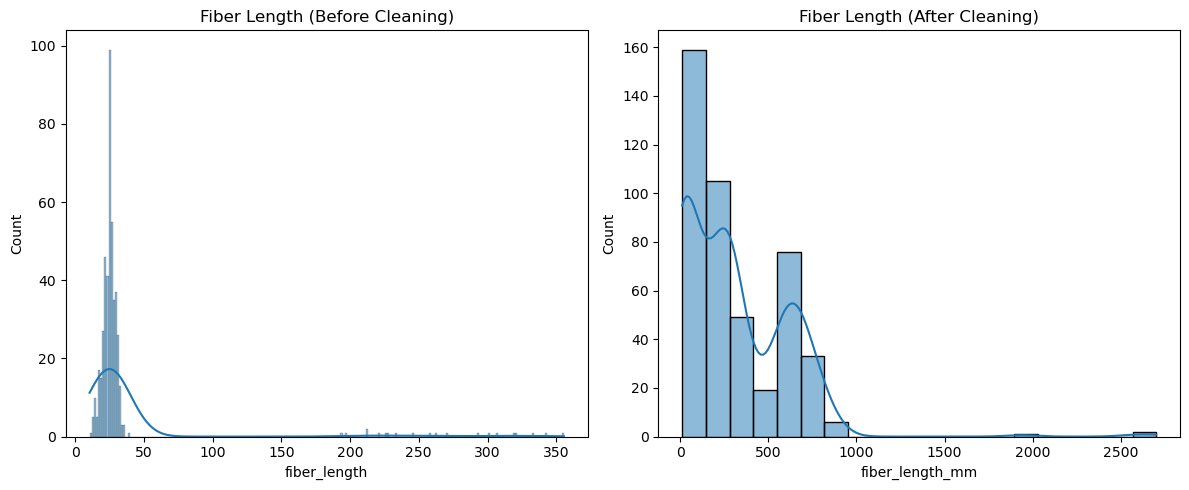

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(raw_data['fiber_length'], ax=axs[0], kde=True)
axs[0].set_title("Fiber Length (Before Cleaning)")

sns.histplot(df_clean['fiber_length_mm'], ax=axs[1], kde=True)
axs[1].set_title("Fiber Length (After Cleaning)")

plt.tight_layout()
plt.show()


In [10]:
df_clean.to_csv("cleaned_data.csv", index=False)


In [11]:
# Summary insights
print("Summary of Cleaned Data:")
print(df_clean.describe())

# Trends by material type (if available)
if 'material_type' in df_clean.columns:
    print("\nAverage fiber length by material type:")
    print(df_clean.groupby('material_type')['fiber_length_mm'].mean())
    
    print("\nMoisture content stats by material type:")
    print(df_clean.groupby('material_type')['moisture_content'].describe())


Summary of Cleaned Data:
       fiber_length  moisture_content  fiber_length_mm
count    450.000000        450.000000       450.000000
mean      31.644824         12.008255       307.289651
std       40.251173          1.721877       310.262745
min       10.521170          7.281416        10.521170
25%       22.376340         10.919760        27.032806
50%       25.447111         11.868534       254.471114
75%       27.945842         13.311960       554.450129
max      342.349923         17.056651      2701.438502
